In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc

In [2]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [28]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 100
epocas = 20
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 32
height = 32
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(58, 14)

In [29]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 70% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 30% de teste

In [30]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5840 validated image filenames belonging to 2 classes.
Found 1460 validated image filenames belonging to 2 classes.


In [31]:
# ShallowNet - Ajustar imagens para 32 x 32
from shallowNet import ShallowNet
shlwClf = ShallowNet()
shlwClf = shlwClf.build(width=width, height=height, depth=3, classes=2)
shlwClf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 65538     
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 66,434
Trainable params: 66,434
Non-trainable params: 0
_________________________________________________________________


c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
print("Shallow Net ***************************************************")
h1 = shlwClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

Shallow Net ***************************************************
Epoch 1/20
58/58 [==============================] - 17s 297ms/step - loss: 0.7046 - accuracy: 0.5836 - val_loss: 0.6236 - val_accuracy: 0.6636
Epoch 2/20
58/58 [==============================] - 17s 294ms/step - loss: 0.6477 - accuracy: 0.6280 - val_loss: 0.6256 - val_accuracy: 0.6679
Epoch 3/20
58/58 [==============================] - 18s 310ms/step - loss: 0.6365 - accuracy: 0.6425 - val_loss: 0.6023 - val_accuracy: 0.6600
Epoch 4/20
58/58 [==============================] - 18s 312ms/step - loss: 0.6099 - accuracy: 0.6739 - val_loss: 0.6708 - val_accuracy: 0.6150
Epoch 5/20
58/58 [==============================] - 18s 314ms/step - loss: 0.6490 - accuracy: 0.6413 - val_loss: 0.6102 - val_accuracy: 0.6607
Epoch 6/20
58/58 [==============================] - 18s 316ms/step - loss: 0.5985 - accuracy: 0.6779 - val_loss: 0.6008 - val_accuracy: 0.6779
Epoch 7/20
58/58 [==============================] - 18s 313ms/step - loss: 0.6

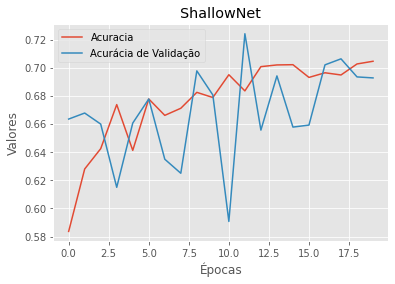

In [34]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
#plt.plot(np.arange(0, epc), h1["loss"], label="Perda")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
#plt.plot(np.arange(0, epc), h1["val_loss"], label="Perda na Validação")
plt.title("ShallowNet")
plt.xlabel("Épocas")
plt.ylabel("Valores")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import classification_report
prdSlhw = shlwClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predShallow = []
for i in prdSlhw:
    predShallow.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predShallow, target_names=["Não Covid", "Covid"]))

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

   Não Covid       0.68      0.64      0.66        44
       Covid       0.73      0.77      0.75        56

    accuracy                           0.71       100
   macro avg       0.71      0.70      0.70       100
weighted avg       0.71      0.71      0.71       100

